# 1. Imports

In [88]:
import gc
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

import plotly.express as px

from atel.data import BookCollection

# 2. Load data - Child Written Books

In [89]:
# load data
book_col = BookCollection(data_file='./data/book_col_271120.pkl')

# Total number of books
print(f'Number of books: {book_col.num_books}')

Loaded from disk: ./data/book_col_271120.pkl
Number of books: 803


## 2.1 Get all attributes for each book

In [90]:
data = []

for i, book in enumerate(book_col):
    if book.code_dict is None:
        print(f'Book with index {i} is None')
        continue
    book.code_dict['book_id'] = i 
    data.append(book.code_dict)

Book with index 509 is None


In [91]:
book_df = pd.DataFrame(data)

In [92]:
list_cols = [
    'Genre', 'Attitude', 'Stavning', 'Perspektiv', 'Tekstbånd', 'Fremstillingsform', 
    'Semantisk univers', 'Stemmer', 'Forbindere', 'Interjektioner'
]

In [93]:
## Replace empty strings with NaN values
book_df = book_df.replace('', np.NaN)

## Explode all columns
# Exploded books
ex_book_df = book_df.copy(deep=True)
for col in list_cols:
    ex_book_df = ex_book_df.explode(col)

del book_df
gc.collect()

0

In [94]:
ex_book_df.head()

,Genre,Attitude,Stavning,Perspektiv,Tekstbånd,Fremstillingsform,Semantisk univers,Holistisk vurdering,Stemmer,book_id,Forbindere,Interjektioner,Metaforbrug,Noter
0,Selvportræt,Bedømmelse positiv,Semifonetisk,Eksplicit fortæller,NaN,Beskrivende,Mennesker,1,En stemme,0,NaN,NaN,NaN,NaN
1,Rim og remser,NaN,Fonetisk,Implicit fortæller,Semantisk,Beskrivende,Vilde dyr,1,En stemme,1,NaN,NaN,NaN,NaN
2,NaN,Følelse 1. person,Semifonetisk,Eksplicit fortæller,NaN,Beskrivende,Mig selv,0,En stemme,2,Tilføjelse,NaN,NaN,NaN
3,Hverdagsbeskrivelse,NaN,Semifonetisk,Implicit fortæller,NaN,Beskrivende,Kæledyr,1,En stemme,3,NaN,NaN,NaN,NaN
3,Hverdagsbeskrivelse,NaN,Fonetisk,Implicit fortæller,NaN,Beskrivende,Kæledyr,1,En stemme,3,NaN,NaN,NaN,NaN


In [95]:
# Replace "Vilde dyr " with "Vilde dyr" (space difference)
ex_book_df[ex_book_df['Semantisk univers'] == 'Vilde dyr\xa0'] = 'Vilde dyr'

## 2.2 Plot distributions of classification columns

In [96]:
def plot_distribution(category: str):
    px.histogram(ex_book_df[['book_id', category]].drop_duplicates(), x=category)\
      .update_xaxes(categoryorder='total descending').show()

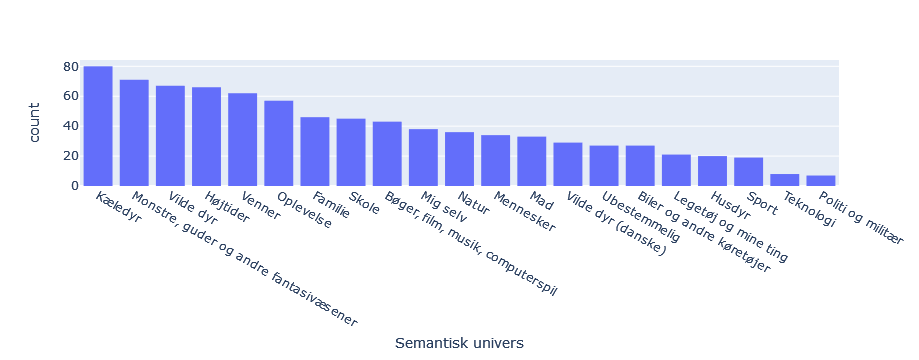

In [97]:
plot_distribution('Semantisk univers')

## 2.3 Get all senteces of each book

In [112]:
def print_book_sentences(book_id: int):
    for page in book_col[book_id].pages:
        for s in page. sentences:
            print(s.text)

In [120]:
book_ids = []
sentences = []

smileys = ['â€\x9d', 'â€œ', ' ðŸŽ„']

for i, book in enumerate(book_col):
    p = []  # for senteces in pages
    for page in book.pages:
        for sentence in page:
            sen = sentence.text.strip()
            
            for smiley in smileys:  # remove smiley
                sen = sen.replace(smiley, '')
                
            if sen != '' and sen[-1] != '.' and sen[-1] != ',':
                sen += '.'
            p.append(sen)
    
    s = ' '.join(p).strip()  # join sentences to one. Remove any beginning or tailing whitespace.
    s = re.sub(' +', ' ', s)
    s = s.replace('\t', '').replace('\n', '')
    
    if s != '':
        sentences.append(s)
        book_ids.append(i)

In [123]:
print_book_sentences(20)

Her er to kaniner.
De spiser gulerødder.
Her er en pige.
Hun har en kanin, der kigger på hende.
Her er en sød kanin.
Jeg har ingen kanin.
Her er en kanin.
den leder efter sin mor.
Man kan også være en forsøgskanin. De
t er ikke en kanin.
Det er et menneske.


In [122]:
sentences[11]

'Løven sover. Så kommer musen. Musen kravler ind i løvens pels. Åååå nej, du må ikke æde mig. . Måske en anden dag, kan jeg hjælpe dig. Haha kun fordi du gider mig.'

In [105]:
for i, s in zip(book_ids, sentences):
    print(i, s)
    print()

0 Jeg er fjollet.

1 A som i abe. B som i bjørn. C som i cykel. D som i dinoæg. E som i elefant. F som i fisk.

2 Her er jeg. Jeg er glad.

3 Holger er en hund.

4 Mormor elsker lasagne.

5 Vi danser rundt om det fine juletræ. Smil for jul, smil for jul. Jeg elsker Valter. Har det sjovt. og danser rundt om juletræet.

6 Det er min lillebror. Han kigger i bladet.

7 Adam skal til Afrika med sin mor og far.A. Adam finder 20 æg. De vil lave mad af dem.

8 Hej ræv. Vil du gerne hjem til mig?. Hej stork. Vil du med mig hjem at spise?. Jeg kan ikke få min mund ned. Namanam. Namenam.

9 Det her er min veninde. Hun hedder Bella. Vi er bedste veninder. , og vi leger altid sammen. , men jeg flyttede. Så kunne vi ikke lege mere, men vi kan ringe til hinanden.

10 Dunkelskoven er ung. Og det er uhyggeligt. Pelle er en alf.

11 Løven sover. Så kommer musen. Musen kravler ind i løvens pels. â€œÅååå nej, du må ikke æde mig. . Måske en anden dag, kan jeg hjælpe dig.â€. Haha kun fordi du gider mig.

1